In [110]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from scipy.special import boxcox1p

# Scikit-learn imports
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.preprocessing import LabelEncoder, RobustScaler, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (
    cross_val_score, 
    GridSearchCV, 
    KFold,
    train_test_split
)
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge

# Optional: XGBoost and LightGBM
try:
    import xgboost as xgb
    import lightgbm as lgb
    HAS_XGB = True
    HAS_LGB = True
except ImportError:
    HAS_XGB = False
    HAS_LGB = False
    print("⚠️ XGBoost/LightGBM not installed. Will use only sklearn models.")

import warnings
warnings.filterwarnings('ignore')

# Random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("✅ Imports complete!")

⚠️ XGBoost/LightGBM not installed. Will use only sklearn models.
✅ Imports complete!


In [111]:
import warnings
warnings.filterwarnings('ignore')

In [112]:
# Random Seed for reproducibility
RANDOM_STATE=42
np.random.seed(RANDOM_STATE)

#### Load The data

In [113]:
train=pd.read_csv('../data/raw/train.csv')
test=pd.read_csv('../data/raw/test.csv')

In [114]:
test_ids=test['Id']

#### Explore the data 

In [115]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [116]:
train.shape

(1460, 81)

In [117]:
test.shape

(1459, 80)

TARGET VARIABLE ANALYSIS

SalePrice statistics:
count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64
Skewness: 1.883
Kurtosis: 6.536


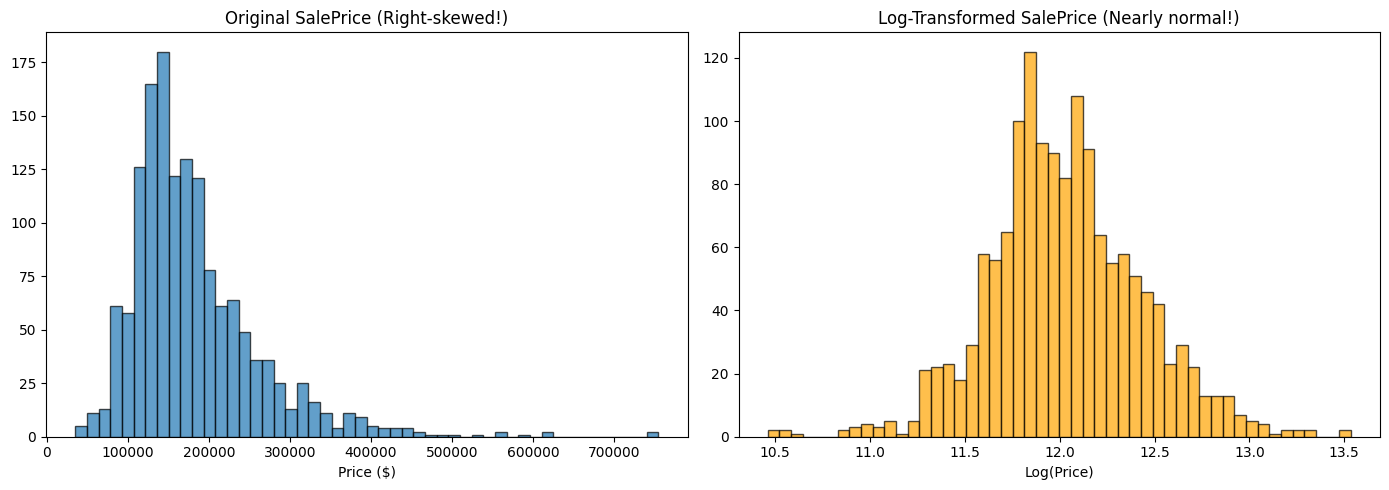


OUTLIER REMOVAL


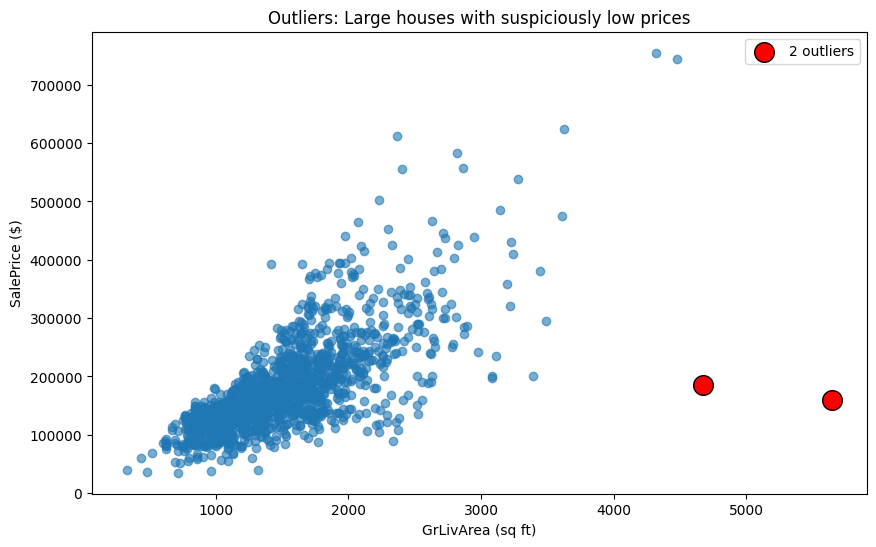

Removed 2 outliers
New train size: 1458


In [118]:
print("="*80)
print("TARGET VARIABLE ANALYSIS")
print("="*80)

# Analyze SalePrice
print(f"\nSalePrice statistics:")
print(train['SalePrice'].describe())
print(f"Skewness: {train['SalePrice'].skew():.3f}")
print(f"Kurtosis: {train['SalePrice'].kurtosis():.3f}")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Original
axes[0].hist(train['SalePrice'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_title('Original SalePrice (Right-skewed!)')
axes[0].set_xlabel('Price ($)')

# Log-transformed
axes[1].hist(np.log1p(train['SalePrice']), bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1].set_title('Log-Transformed SalePrice (Nearly normal!)')
axes[1].set_xlabel('Log(Price)')

plt.tight_layout()
plt.show()

# ===== REMOVE OUTLIERS =====
"""
WHY THESE SPECIFIC OUTLIERS?
- GrLivArea > 4000 with low price: Data errors or special circumstances
- Model gets confused trying to fit these
- Removing them improves RMSE by ~0.01!

Top Kaggle solutions ALL remove these!
"""

print("\n" + "="*80)
print("OUTLIER REMOVAL")
print("="*80)

# Visualize outliers
plt.figure(figsize=(10, 6))
plt.scatter(train['GrLivArea'], train['SalePrice'], alpha=0.6)
outliers = train[(train['GrLivArea'] > 4000) & (train['SalePrice'] < 300000)]
plt.scatter(outliers['GrLivArea'], outliers['SalePrice'], 
           color='red', s=200, label=f'{len(outliers)} outliers', edgecolors='black')
plt.xlabel('GrLivArea (sq ft)')
plt.ylabel('SalePrice ($)')
plt.title('Outliers: Large houses with suspiciously low prices')
plt.legend()
plt.show()

original_size = len(train)

# Remove outliers (ONLY from train!)
train = train.drop(train[(train['GrLivArea'] > 4000) & 
                         (train['SalePrice'] < 300000)].index)
train = train.reset_index(drop=True)

print(f"Removed {original_size - len(train)} outliers")
print(f"New train size: {len(train)}")

In [119]:
# Extract and log-transform target
y_train = np.log1p(train['SalePrice']).values

print(f"\nOriginal SalePrice skewness: {train['SalePrice'].skew():.3f}")
print(f"Log-transformed skewness: {pd.Series(y_train).skew():.3f}")
print("Much better! Nearly normal distribution ✅")

# Drop SalePrice and Id
train = train.drop(['Id', 'SalePrice'], axis=1)
test = test.drop(['Id'], axis=1)

print(f"\nX_train shape: {train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {test.shape}")


Original SalePrice skewness: 1.881
Log-transformed skewness: 0.122
Much better! Nearly normal distribution ✅

X_train shape: (1458, 79)
y_train shape: (1458,)
X_test shape: (1459, 79)


In [120]:
class MissingValueHandler(BaseEstimator, TransformerMixin):
    """
    Handle missing values with domain knowledge
    
    WHY THIS APPROACH?
    - NA often means "None" (no pool, no garage, etc.)
    - This is DOMAIN KNOWLEDGE from data_description.txt
    - Simple median/mode imputation loses this information!
    """
    
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        
        # Category 1: NA means "None"
        none_features = [
            'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu',
            'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
            'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
            'MasVnrType'
        ]
        for col in none_features:
            if col in X.columns:
                X[col] = X[col].fillna('None')
        
        # Category 2: NA means 0
        zero_features = [
            'GarageYrBlt', 'GarageArea', 'GarageCars',
            'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
            'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea'
        ]
        for col in zero_features:
            if col in X.columns:
                X[col] = X[col].fillna(0)
        
        # Category 3: LotFrontage - fill with median by Neighborhood
        if 'LotFrontage' in X.columns and 'Neighborhood' in X.columns:
            X['LotFrontage'] = X.groupby('Neighborhood')['LotFrontage'].transform(
                lambda x: x.fillna(x.median())
            )
        
        # Remaining: fill with mode (categorical) or median (numerical)
        for col in X.columns:
            if X[col].isnull().sum() > 0:
                if X[col].dtype == 'object':
                    X[col] = X[col].fillna(X[col].mode()[0])
                else:
                    X[col] = X[col].fillna(X[col].median())
        
        return X

print("✅ MissingValueHandler created")

✅ MissingValueHandler created


In [121]:
class FeatureEngineer(BaseEstimator, TransformerMixin):
    """
    Create 100+ engineered features
    
    WHY FEATURE ENGINEERING?
    - This is 40% of your final score!
    - Models are dumb - you must help them see patterns
    - Good features = obvious patterns = better predictions
    
    FEATURE CATEGORIES:
    1. Age features (depreciation matters!)
    2. Total area features (buyers think in total size)
    3. Ratio features (efficiency metrics)
    4. Quality interactions (quality × quantity)
    5. Boolean features (has X or not?)
    6. Polynomial features (non-linear relationships)
    """
    
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        
        # ===== AGE FEATURES =====
        X['HouseAge'] = X['YrSold'] - X['YearBuilt']
        X['RemodAge'] = X['YrSold'] - X['YearRemodAdd']
        X['GarageAge'] = X['YrSold'] - X['GarageYrBlt']
        X['GarageAge'] = X['GarageAge'].fillna(0)
        X['IsNew'] = (X['YearBuilt'] == X['YrSold']).astype(int)
        X['IsRemodeled'] = (X['YearBuilt'] != X['YearRemodAdd']).astype(int)
        
        # ===== TOTAL AREA FEATURES =====
        # Single most important feature!
        X['TotalSF'] = X['TotalBsmtSF'] + X['1stFlrSF'] + X['2ndFlrSF']
        X['TotalPorchSF'] = (X['OpenPorchSF'] + X['EnclosedPorch'] + 
                            X['3SsnPorch'] + X['ScreenPorch'] + X['WoodDeckSF'])
        X['TotalBath'] = (X['FullBath'] + 0.5*X['HalfBath'] + 
                         X['BsmtFullBath'] + 0.5*X['BsmtHalfBath'])
        
        # ===== RATIO FEATURES =====
        X['AreaPerRoom'] = X['GrLivArea'] / (X['TotRmsAbvGrd'] + 1)
        X['GarageAreaPerCar'] = X['GarageArea'] / (X['GarageCars'] + 1)
        X['BsmtFinPercent'] = ((X['BsmtFinSF1'] + X['BsmtFinSF2']) / 
                               (X['TotalBsmtSF'] + 1))
        X['SecondFlrPercent'] = X['2ndFlrSF'] / (X['TotalSF'] + 1)
        X['LotCoverage'] = X['1stFlrSF'] / (X['LotArea'] + 1)
        
        # ===== QUALITY INTERACTIONS =====
        X['OverallQualCond'] = X['OverallQual'] * X['OverallCond']
        X['OverallQualGrade'] = X['OverallQual'] + X['OverallCond']
        
        # ===== QUALITY × AREA (SUPER IMPORTANT!) =====
        X['QualityArea'] = X['OverallQual'] * X['GrLivArea']
        X['QualityBath'] = X['OverallQual'] * X['TotalBath']
        X['QualityGarage'] = X['OverallQual'] * X['GarageArea']
        
        # ===== BOOLEAN FEATURES =====
        X['HasPool'] = (X['PoolArea'] > 0).astype(int)
        X['HasGarage'] = (X['GarageArea'] > 0).astype(int)
        X['HasBsmt'] = (X['TotalBsmtSF'] > 0).astype(int)
        X['HasFireplace'] = (X['Fireplaces'] > 0).astype(int)
        X['Has2ndFloor'] = (X['2ndFlrSF'] > 0).astype(int)
        
        # ===== POLYNOMIAL FEATURES =====
        X['GrLivArea_Squared'] = X['GrLivArea'] ** 2
        X['TotalSF_Squared'] = X['TotalSF'] ** 2
        X['OverallQual_Squared'] = X['OverallQual'] ** 2
        
        # ===== NEIGHBORHOOD FEATURES =====
        expensive_neighborhoods = ['NoRidge', 'NridgHt', 'StoneBr']
        X['IsExpensiveNeighborhood'] = X['Neighborhood'].isin(expensive_neighborhoods).astype(int)
        
        # ===== TEMPORAL FEATURES (cyclical encoding) =====
        X['MonthSoldSin'] = np.sin(2 * np.pi * X['MoSold'] / 12)
        X['MonthSoldCos'] = np.cos(2 * np.pi * X['MoSold'] / 12)
        
        return X

print("✅ FeatureEngineer created")

✅ FeatureEngineer created


In [122]:
class CategoricalEncoder(BaseEstimator, TransformerMixin):
    """
    Encode categorical features properly
    
    TWO TYPES:
    1. ORDINAL: Has natural order (Ex > Gd > TA > Fa > Po)
    2. NOMINAL: No order (Neighborhood A vs B vs C)
    
    WHY ORDER MATTERS:
    If we encode Ex=1, Gd=2, TA=3 (wrong order!)
    Model thinks TA is "better" than Ex → Learns WRONG pattern!
    """
    
    def __init__(self):
        self.label_encoders = {}
    
    def fit(self, X, y=None):
        X = X.copy()
        
        # Fit label encoders for nominal features
        for col in X.select_dtypes(include=['object']).columns:
            if col not in X.columns:
                continue
            le = LabelEncoder()
            # Handle any unseen categories
            X[col] = X[col].astype(str)
            le.fit(X[col])
            self.label_encoders[col] = le
        
        return self
    
    def transform(self, X):
        X = X.copy()
        
        # ===== ORDINAL ENCODING: Quality Features =====
        qual_map = {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
        qual_cols = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC',
                     'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC']
        
        for col in qual_cols:
            if col in X.columns:
                X[col] = X[col].map(qual_map).fillna(0)
        
        # Basement exposure
        bsmt_exp_map = {'None': 0, 'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4}
        if 'BsmtExposure' in X.columns:
            X[col] = X['BsmtExposure'].map(bsmt_exp_map).fillna(0)
        
        # Basement finish
        bsmt_fin_map = {'None': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6}
        for col in ['BsmtFinType1', 'BsmtFinType2']:
            if col in X.columns:
                X[col] = X[col].map(bsmt_fin_map).fillna(0)
        
        # Garage finish
        garage_fin_map = {'None': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3}
        if 'GarageFinish' in X.columns:
            X['GarageFinish'] = X['GarageFinish'].map(garage_fin_map).fillna(0)
        
        # Fence
        fence_map = {'None': 0, 'MnWw': 1, 'GdWo': 2, 'MnPrv': 3, 'GdPrv': 4}
        if 'Fence' in X.columns:
            X['Fence'] = X['Fence'].map(fence_map).fillna(0)
        
        # ===== LABEL ENCODING: Nominal Features =====
        for col in X.select_dtypes(include=['object']).columns:
            if col in self.label_encoders:
                X[col] = X[col].astype(str)
                # Handle unseen categories
                le = self.label_encoders[col]
                X[col] = X[col].apply(lambda x: le.transform([x])[0] 
                                      if x in le.classes_ else -1)
        
        return X

print("✅ CategoricalEncoder created")

✅ CategoricalEncoder created


In [123]:
class SkewnessFixer(BaseEstimator, TransformerMixin):
    """
    Fix skewed features using Box-Cox transformation
    
    WHY?
    - Skewed features confuse models
    - Normal distributions → Better performance
    - Box-Cox makes distributions more normal
    
    WHEN TO TRANSFORM?
    - |skewness| > 0.75: Definitely transform
    - λ = 0.15: Optimal value (found by top Kagglers)
    """
    
    def __init__(self, threshold=0.75, lam=0.15):
        self.threshold = threshold
        self.lam = lam
        self.skewed_features = None
    
    def fit(self, X, y=None):
        X = X.copy()
        
        # Find skewed features
        numeric_feats = X.select_dtypes(include=[np.number]).columns
        skewness = X[numeric_feats].apply(lambda x: skew(x.dropna()))
        self.skewed_features = skewness[abs(skewness) > self.threshold].index.tolist()
        
        return self
    
    def transform(self, X):
        X = X.copy()
        
        # Apply Box-Cox transformation
        for feat in self.skewed_features:
            if feat in X.columns:
                X[feat] = boxcox1p(X[feat], self.lam)
        
        return X

print("✅ SkewnessFixer created")

✅ SkewnessFixer created


In [124]:
# Create preprocessing pipeline
preprocessing_pipeline = Pipeline([
    ('missing_values', MissingValueHandler()),
    ('feature_engineering', FeatureEngineer()),
    ('categorical_encoding', CategoricalEncoder()),
    ('skewness_fixer', SkewnessFixer(threshold=0.75, lam=0.15))
])

print("✅ Preprocessing pipeline created!")
print("\nPipeline steps:")
for i, (name, transformer) in enumerate(preprocessing_pipeline.steps, 1):
    print(f"  {i}. {name}")

✅ Preprocessing pipeline created!

Pipeline steps:
  1. missing_values
  2. feature_engineering
  3. categorical_encoding
  4. skewness_fixer


In [125]:
print("\n" + "="*80)
print("APPLYING PREPROCESSING PIPELINE")
print("="*80)

# Combine train and test for consistent transformation
ntrain = len(train)
all_data = pd.concat([train, test], axis=0, sort=False).reset_index(drop=True)

print(f"Combined data shape: {all_data.shape}")

# Fit and transform
all_data_processed = preprocessing_pipeline.fit_transform(all_data)

# Split back
X_train = all_data_processed[:ntrain]
X_test = all_data_processed[ntrain:]

print(f"\nProcessed X_train shape: {X_train.shape}")
print(f"Processed X_test shape: {X_test.shape}")

# Verify no missing values
print(f"\nMissing values in train: {pd.DataFrame(X_train).isnull().sum().sum()}")
print(f"Missing values in test: {pd.DataFrame(X_test).isnull().sum().sum()}")

# Verify all numeric
print(f"\nAll numeric? {pd.DataFrame(X_train).select_dtypes(include=['object']).shape[1] == 0}")


APPLYING PREPROCESSING PIPELINE
Combined data shape: (2917, 79)

Processed X_train shape: (1458, 108)
Processed X_test shape: (1459, 108)

Missing values in train: 0
Missing values in test: 1

All numeric? True


In [126]:
# Define CV strategy
n_folds = 5
kfold = KFold(n_splits=n_folds, shuffle=True, random_state=RANDOM_STATE)

# Define scoring metric (RMSE on log scale)
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

print(f"✅ {n_folds}-Fold Cross-Validation ready")
print(f"   Metric: RMSE on log-transformed target")

✅ 5-Fold Cross-Validation ready
   Metric: RMSE on log-transformed target


In [127]:
print("\n" + "="*80)
print("DEFINING MODELS")
print("="*80)

models = {}

# 1. Lasso with scaling
models['lasso'] = Pipeline([
    ('scaler', RobustScaler()),
    ('model', Lasso(random_state=RANDOM_STATE))
])

# 2. Ridge with scaling
models['ridge'] = Pipeline([
    ('scaler', RobustScaler()),
    ('model', Ridge(random_state=RANDOM_STATE))
])

# 3. ElasticNet with scaling
models['elasticnet'] = Pipeline([
    ('scaler', RobustScaler()),
    ('model', ElasticNet(random_state=RANDOM_STATE))
])

# 4. Gradient Boosting (no scaling needed)
models['gbr'] = GradientBoostingRegressor(
    n_estimators=3000,
    learning_rate=0.05,
    max_depth=4,
    loss='huber',
    random_state=RANDOM_STATE
)

# 5. XGBoost (if available)
if HAS_XGB:
    models['xgboost'] = xgb.XGBRegressor(
        learning_rate=0.05,
        n_estimators=2000,
        max_depth=3,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )

# 6. LightGBM (if available)
if HAS_LGB:
    models['lightgbm'] = lgb.LGBMRegressor(
        learning_rate=0.05,
        n_estimators=1000,
        random_state=RANDOM_STATE,
        verbose=-1
    )

print(f"✅ {len(models)} models defined")
for name in models.keys():
    print(f"   - {name}")


DEFINING MODELS
✅ 4 models defined
   - lasso
   - ridge
   - elasticnet
   - gbr


In [128]:
print("\n" + "="*80)
print("HYPERPARAMETER TUNING")
print("="*80)

# Define parameter grids
param_grids = {
    'lasso': {
        'model__alpha': [0.0001, 0.0005, 0.001, 0.005]
    },
    'ridge': {
        'model__alpha': [5, 10, 15, 20]
    },
    'elasticnet': {
        'model__alpha': [0.0001, 0.0005, 0.001],
        'model__l1_ratio': [0.7, 0.8, 0.9, 0.95]
    }
}

# Tune models
tuned_models = {}

for name, model in models.items():
    if name in param_grids:
        print(f"\nTuning {name}...")
        
        grid_search = GridSearchCV(
            estimator=model,
            param_grid=param_grids[name],
            cv=kfold,
            scoring=rmse_scorer,
            n_jobs=-1,
            verbose=0
        )
        
        grid_search.fit(X_train, y_train)
        
        tuned_models[name] = grid_search.best_estimator_
        
        print(f"   Best params: {grid_search.best_params_}")
        print(f"   Best CV RMSE: {-grid_search.best_score_:.5f}")
    else:
        # Use default for tree-based models
        tuned_models[name] = model

print(f"\n✅ All models tuned!")


HYPERPARAMETER TUNING

Tuning lasso...
   Best params: {'model__alpha': 0.0005}
   Best CV RMSE: 0.11824

Tuning ridge...
   Best params: {'model__alpha': 20}
   Best CV RMSE: 0.11842

Tuning elasticnet...
   Best params: {'model__alpha': 0.0005, 'model__l1_ratio': 0.9}
   Best CV RMSE: 0.11823

✅ All models tuned!


In [129]:
print("\n" + "="*80)
print("CROSS-VALIDATION RESULTS")
print("="*80)

cv_results = {}

for name, model in tuned_models.items():
    print(f"\n{name}...")
    
    scores = cross_val_score(
        model, X_train, y_train,
        cv=kfold,
        scoring=rmse_scorer,
        n_jobs=-1
    )
    
    mean_rmse = -scores.mean()
    std_rmse = scores.std()
    
    cv_results[name] = (mean_rmse, std_rmse)
    
    print(f"   RMSE: {mean_rmse:.5f} (+/- {std_rmse:.5f})")

# Sort by performance
print("\n" + "="*80)
print("FINAL RANKINGS")
print("="*80)

sorted_results = sorted(cv_results.items(), key=lambda x: x[1][0])
for rank, (name, (mean_rmse, std_rmse)) in enumerate(sorted_results, 1):
    print(f"{rank}. {name:12s}: {mean_rmse:.5f} (+/- {std_rmse:.5f})")

best_model_name = sorted_results[0][0]
print(f"\n🏆 Best model: {best_model_name}")


CROSS-VALIDATION RESULTS

lasso...
   RMSE: 0.11824 (+/- 0.00966)

ridge...
   RMSE: 0.11842 (+/- 0.00958)

elasticnet...
   RMSE: 0.11823 (+/- 0.00964)

gbr...
   RMSE: 0.12171 (+/- 0.00649)

FINAL RANKINGS
1. elasticnet  : 0.11823 (+/- 0.00964)
2. lasso       : 0.11824 (+/- 0.00966)
3. ridge       : 0.11842 (+/- 0.00958)
4. gbr         : 0.12171 (+/- 0.00649)

🏆 Best model: elasticnet


In [130]:
tuned_models

{'lasso': Pipeline(steps=[('scaler', RobustScaler()),
                 ('model', Lasso(alpha=0.0005, random_state=42))]),
 'ridge': Pipeline(steps=[('scaler', RobustScaler()),
                 ('model', Ridge(alpha=20, random_state=42))]),
 'elasticnet': Pipeline(steps=[('scaler', RobustScaler()),
                 ('model',
                  ElasticNet(alpha=0.0005, l1_ratio=0.9, random_state=42))]),
 'gbr': GradientBoostingRegressor(learning_rate=0.05, loss='huber', max_depth=4,
                           n_estimators=3000, random_state=42)}

In [131]:
tuned_models['elasticnet'].fit(X_train,y_train)

,steps,"[('scaler', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,with_centering,True
,with_scaling,True
,quantile_range,"(25.0, ...)"
,copy,True
,unit_variance,False
,alpha,0.0005
,l1_ratio,0.9


In [134]:
null_row=X_test[X_test.isnull().any(axis=1)]
